## Imports

This function creates the Model RDMs that are used to compare to each searchlight in the data RDM.

It (should) take the following inputs:
- the order that the participant sees the stimuli

Important output (at the moment) is
- the model RDMs object. This object is used to compare to the data RDMs in the searchlight analysis.

Notes:
- The model RDM can either
  -  be constructed by the user. e.g. `replay_model` which has specific predictions.
  -  be calculated from the a "vector" or "neural" model. This is where the model RDM object is made from a set of (artifically constructed) neural responses that correspond to the behaviour / stimulus that the participant encounted. 

The important functions should be: 
- Function to construct the model RDM from the vector model
- Function to put your own a model RDM into the correct format for the searchlight analysis
- Saving the model RDM (as a single model)


For future analysis, the model RDMs can be used in combination. We need a way of saving different hypotheses as different model RDMs objects. 
These can then be loaded into the searchlight analysis. The combination models will be made just before the searchlight analysis. 

In [4]:
# Auto reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Standard Libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
from pathlib import Path
# RSA specific libraries

# Multiple Clocks Repositiory
import mc.analyse.analyse_MRI_behav     as analyse_MRI_behav
import mc.analyse.extract_and_clean     as extract_and_clean
import mc.simulation.predictions        as predictions
import mc.simulation.RDMs               as RDMs
import mc.replay_analysis.functions.utils      as utils
import mc.replay_analysis.functions.visualise  as v
import mc.replay_analysis.functions.model_rdms as model_rdms
import mc.replay_analysis.functions.data_rdms  as data_rdms



In [6]:

REGRESSION_VERSION = '01' 
RDM_VERSION        = '01-2' 
SUBJECT_NO         = '01'

# Behavioural data directory
DATA_DIR = Path("/Users/student/PycharmProjects/data")
DATA_DIR_BEHAV = DATA_DIR / 'raw' / 'sub-{SUBJECT_NO}' / 'beh'

TEMPORAL_RESOLUTION = 10
subjects_list: list = [f"sub-{SUBJECT_NO}"]
sub = subjects_list[0]
task_halves: list = ['1', '2']

# Flag to plot the RDMs
FMRI_PLOTTING = True
# Flag to save the RDMs and the regressors
FMRI_SAVE = True
RDM_SIMILARITY_MEASURE = "pearson" # default is 'pearson'
ADD_RUN_COUNTS_MODEL = False # this doesn't work with the current analysis

# Get the list of the models to analyse  
models_i_want: list = analyse_MRI_behav.models_I_want(RDM_VERSION)



## get correct working directory

In [64]:
configs_dict = {}
models_between_task_halves = {}

# Select the correct file path as a directory for the behavioural .csv file
DATA_DIR_BEHAV = DATA_DIR / 'raw' / f'{sub}' / 'beh'

RDM_dir = DATA_DIR / 'derivatives' / f'{sub}' / 'beh' / f'RDMs_{RDM_VERSION}_glmbase_{REGRESSION_VERSION}'

if os.path.isdir(DATA_DIR_BEHAV):
    print("Running on laptop.")
else:
    DATA_DIR_BEHAV = DATA_DIR / f'{sub}' / 'beh'
    RDM_dir = '{DATA_DIR}' /'derivatives' / f'{sub}' / 'beh' / 'RDMs_{RDM_VERSION}_glmbase_{REGRESSION_VERSION}'
    print(f"Running on Cluster, setting {DATA_DIR_BEHAV} as data directory")


# for each half of the task do the following
for task_half in task_halves:
    # 1. Extract the behavioural data from the .csv to appropriate dictionaries
        
    # file = data_dir_behav + f"{sub}_fmri_pt{task_half}.csv"
    file = f"{DATA_DIR}/raw/sub-01/beh" + f"/{sub}_fmri_pt{task_half}.csv"
    print(file)
    # 1. Extract the behavioural data from the .csv to appropriate dictionaries
    configs, rew_list, rew_index, walked_path, steps_subpath_alltasks_empty, subpath_after_steps, timings, regressors = analyse_MRI_behav.extract_behaviour(file)

    # 2. Create the regressors for the GLM
    # so now, account for the temporal resolution that you want
    for reg in regressors:
        # For each regressor, 
        regressors[reg] = np.repeat(regressors[reg], repeats = TEMPORAL_RESOLUTION)
    
    # Overview of the reward fields per task.
    steps_subpath_alltasks = analyse_MRI_behav.subpath_files(configs, subpath_after_steps, rew_list, rew_index, steps_subpath_alltasks_empty)

    # prepare the between-tasks dictionary.
    all_models_dict = {f"{model}": {key: "" for key in configs} for model in models_i_want}

    # then, lastly, save the all_models_dict in the respective task_half.
    models_between_task_halves[task_half] = all_models_dict
    print(f"task half {task_half}")
    configs_dict[task_half] = rew_list





Running on laptop.
/Users/student/PycharmProjects/data/raw/sub-01/beh/sub-01_fmri_pt1.csv
task half 1
/Users/student/PycharmProjects/data/raw/sub-01/beh/sub-01_fmri_pt2.csv
task half 2


- Get the order of the stimuli that the participant sees
- Create the model RDMs object
- save it to folder with a good name
- 

In [71]:
RDM_VERSION = '01-2'

from rsatoolbox.rdm.rdms import RDMs

# Create sorted_keys_dict for the RDMs
sorted_keys_dict = extract_and_clean.order_task_according_to_rewards(configs_dict)
execution_order = analyse_MRI_behav.get_execution_order(
    configs_dict = configs_dict,
)
# # create dictionary (for both halves, splits) that contains the neural model for each condition being tested
# replay_RDM_object = model_rdms.task_similarity_matrix(
#     configs_dict = configs_dict,
#     model = "replay",
#     RDM_dir = RDM_dir,
#     VISUALISE = True
#     )
execution_order['1'].sort(), execution_order['2'].sort()
EVs = execution_order['1'] + execution_order['2']

model = model_rdms.crosscorr_matrix(EVs)

model = model.reshape(1, 10, 10)


obj1 = RDMs(
    dissimilarities = model, 
    # dissimilarity_measure = 'test',
    # descriptors = EVs
)

obj2 = obj1.subset_pattern(
    by = "index", 
    value = [0, 3, 6]
)

obj2.get_matrices(), obj1.get_matrices()



A 1 f
B 2 b


(array([[[ 0.  ,  0.25, -0.25],
         [ 0.25,  0.  ,  0.25],
         [-0.25,  0.25,  0.  ]]]),
 array([[[ 0.  , -1.  , -0.25,  0.25, -0.25,  0.25, -0.25,  0.25, -0.25,
           0.25],
         [-1.  ,  0.  ,  0.25, -0.25,  0.25, -0.25,  0.25, -0.25,  0.25,
          -0.25],
         [-0.25,  0.25,  0.  , -1.  , -0.25,  0.25, -0.25,  0.25, -0.25,
           0.25],
         [ 0.25, -0.25, -1.  ,  0.  ,  0.25, -0.25,  0.25, -0.25,  0.25,
          -0.25],
         [-0.25,  0.25, -0.25,  0.25,  0.  , -1.  , -0.25,  0.25, -0.25,
           0.25],
         [ 0.25, -0.25,  0.25, -0.25, -1.  ,  0.  ,  0.25, -0.25,  0.25,
          -0.25],
         [-0.25,  0.25, -0.25,  0.25, -0.25,  0.25,  0.  , -1.  , -0.25,
           0.25],
         [ 0.25, -0.25,  0.25, -0.25,  0.25, -0.25, -1.  ,  0.  ,  0.25,
          -0.25],
         [-0.25,  0.25, -0.25,  0.25, -0.25,  0.25, -0.25,  0.25,  0.  ,
          -1.  ],
         [ 0.25, -0.25,  0.25, -0.25,  0.25, -0.25,  0.25, -0.25, -1.  ,
         

In [178]:
# replay_RDM_object.pattern_descriptors
# RDM_dir

A 1 b
B 1 f
A1_backw A1_backw
Same task, task half and direction
A1_backw A1_forw
A1_backw B1_backw
A1_backw B1_forw
A1_backw C1_backw
A1_backw C1_forw
A1_backw D1_backw
A1_backw D1_forw
A1_backw E1_backw
A1_backw E1_forw
A1_backw A2_forw
A1_backw A2_backw
A1_backw B2_forw
A1_backw B2_backw
A1_backw C2_forw
A1_backw C2_backw
A1_backw D2_forw
A1_backw D2_backw
A1_backw E2_forw
A1_backw E2_backw
A1_forw A1_backw
A1_forw A1_forw
Same task, task half and direction
A1_forw B1_backw
A1_forw B1_forw
A1_forw C1_backw
A1_forw C1_forw
A1_forw D1_backw
A1_forw D1_forw
A1_forw E1_backw
A1_forw E1_forw
A1_forw A2_forw
A1_forw A2_backw
A1_forw B2_forw
A1_forw B2_backw
A1_forw C2_forw
A1_forw C2_backw
A1_forw D2_forw
A1_forw D2_backw
A1_forw E2_forw
A1_forw E2_backw
B1_backw A1_backw
B1_backw A1_forw
B1_backw B1_backw
Same task, task half and direction
B1_backw B1_forw
B1_backw C1_backw
B1_backw C1_forw
B1_backw D1_backw
B1_backw D1_forw
B1_backw E1_backw
B1_backw E1_forw
B1_backw A2_forw
B1_backw A2

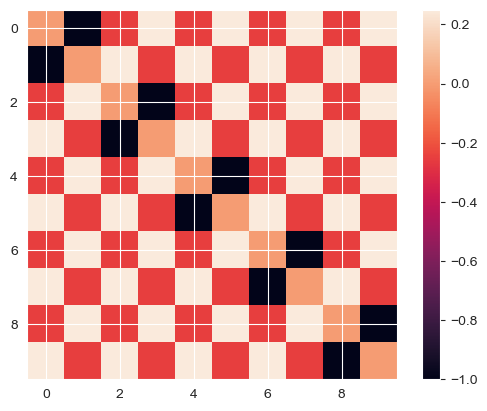

In [175]:
rdm = model_rdms.task_similarity_matrix(
    configs_dict = configs_dict,
    model = "replay-2",
    RDM_dir = RDM_dir,
    VISUALISE = False
    )

plt.imshow(rdm.get_matrices()[0])
plt.colorbar()


In [179]:
# replay_RDM_object

## Remove the autocorrelation from the model 

In [180]:
# replay_RDM_object.dissimilarities.shape
# rdm_object

In [38]:
corrected_RDM = analyse_MRI_behav.auto_corr_RDM_obj(
    RDM_obj = replay_RDM_object,
)

arr = replay_RDM_object.get_matrices()
plt.imshow(arr[0])

KeyboardInterrupt: 

In [6]:

# then, in a last step, create the RDMs
# concatenate the conditions from the two task halves (giving you 2*nCond X nVoxels matrix), 
# and calculate the correlations between all rows of this matrix. This gives you a symmetric matrix 
# (of size 2*nCond X 2*nCond), where the (non-symmetric) nCond X nCond bottom left square (or top right, 
# doesn't matter because it's symmetric) (i.e. a quarter of the original matrix) has all the correlations 
# across THs. 

# NOTE: the formatting for these dictationaries are the opposite nesting of what is expected from the script.
# reverse the nesting of the dictionaries.

# flip the keys and values of the dictionary.
models_sorted_into_splits = utils.reverse_nested_dict(models_sorted_into_splits)

# FROM THE NEURAL MODELS, CREATE THE RDMs

# for each split (half)
for split in models_sorted_into_splits:
    RSM_dict_betw_TH = {}
    # for each model in the split (half), create the RSM and place it in a dictionary
    for model in models_sorted_into_splits[split]:
        RSM_dict_betw_TH[model] = RDMs.construct_within_task_RSM(
            # The matrix being used is the concatenation of the models between both task halves
            neuron_activation_matrix = np.concatenate(
                # First half of task (as a vector for each EV)
                (models_sorted_into_splits['1'][model],
                # Second half of task
                models_sorted_into_splits['2'][model]),
                # the axis along which the concatenation is done
                1), 
            SIMILARITY_MEASURE = RDM_SIMILARITY_MEASURE,
            plotting    = True, 
            titlestring = model,
            neural_model = False)

        
# correct the RSM for dealing with two task halves being autocorrlated in time
corrected_RSM_dict = analyse_MRI_behav.auto_corr_RSM_dict(RSM_dict_betw_TH)


# just for me. what happens if I add the ['reward_location', 'one_future_rew_loc' ,'two_future_rew_loc', 'three_future_rew_loc']?
# addition_model = corrected_RSM_dict['reward_location'] + corrected_RSM_dict['one_future_rew_loc'] + corrected_RSM_dict['two_future_rew_loc'] + corrected_RSM_dict['three_future_rew_loc'] 


NameError: name 'models_sorted_into_splits' is not defined

## For your own visiualisation and saving

In [ ]:

# Plot the RDMs
if FMRI_PLOTTING == True:
    # create directory for saving the RDM images
    if not os.path.exists(RDM_dir):
        os.makedirs(RDM_dir)

    # plot the RDMs from the RSM dictionary
    RDMs.plot_RDMs(
        RDM_dict = corrected_RSM_dict, 
        save_dir = RDM_dir, 
        string_for_ticks = sorted_keys_dict['1'])

# Save the RDMs
if FMRI_SAVE == True: 
    # then save these matrices.
    if not os.path.exists(RDM_dir):
        os.makedirs(RDM_dir)
    for RDM in corrected_RSM_dict:
        np.save(os.path.join(RDM_dir, f"RSM_{RDM}_{sub}_fmri_both_halves"), corrected_RSM_dict[RDM])

    # also save the regression files
    for model in models_sorted_into_splits['1']:
        np.save(os.path.join(RDM_dir, f"data{model}_{sub}_fmri_both_halves"), np.concatenate(
            (models_sorted_into_splits['1'][model], 
             models_sorted_into_splits['2'][model]),
                1))
    
    # and lastly, save the order in which I put the RDMs.

    # save the sorted keys and the regressors.
    with open(f"{RDM_dir}/sorted_keys-model_RDMs.pkl", 'wb') as file:
        pickle.dump(sorted_keys_dict, file)
    
    with open(f"{RDM_dir}/sorted_regs.pkl", 'wb') as file:
        pickle.dump(reg_list, file)
            


